<a href="https://colab.research.google.com/github/Sebastian-Frey/ML/blob/main/L3A_Surfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Engineering of Data Analysis: assignment 1

By delivering this notebook, we confirm that the code presented was developed by the following students.

**Student num:** 66172     **; Name:** Sebastian Frey

**Student num:** 68336     **; Name:** Felix Bührmann

**DEADLINE:** 21st April, 23h59

**Only one student should deliver the notebook**


**IMPORTANT:** To use GPUs in Colab, you need to go to the menu ```Edit > Notebook settings``` and select GPU as the hardware accelerator.

Some useful links:
* [ACM DEBS 2015 Grand Challenge](http://www.debs2015.org/call-grand-challenge.html)

* [Spark web site](https://spark.apache.org/)

* [Spark MLlib main page](https://spark.apache.org/mllib/)
* [Spark MLlib guide](https://spark.apache.org/docs/latest/ml-guide.html)

* [CuDF documentation](https://docs.rapids.ai/api/cudf/stable/)
* [cuML documentation](https://docs.rapids.ai/api/cuml/stable/)


# Install software

In [1]:
# Software to download files
!pip install gdown

In [2]:
# Install Spark
!apt-get install openjdk-17-jdk-headless
!pip install pyspark==4.0.0.dev2
!mkdir checkpoint


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  openjdk-17-jre-headless
Suggested packages:
  openjdk-17-demo openjdk-17-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-17-jdk-headless openjdk-17-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 120 MB of archives.
After this operation, 271 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jre-headless amd64 17.0.14+7-1~22.04.1 [48.3 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jdk-headless amd64 17.0.14+7-1~22.04.1 [71.3 MB]
Fetched 120 MB in 7s (17.4 MB/s)
Selecting previously unselected package openjdk-17-jre-headless:amd64.
(Reading database ...

In [3]:
# Install RAPIDS - for using cuDF, cuML
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible,
# it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 592 (delta 125), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (592/592), 194.79 KiB | 435.00 KiB/s, done.
Resolving deltas: 100% (299/299), done.
Installing RAPIDS remaining 25.04 libraries
Using Python 3.11.12 environment at: /usr
Resolved 173 packages in 11.38s
 Downloaded cuproj-cu12
 Downloaded rmm-cu12
 Downloaded shapely
 Downloaded datashader
 Downloaded pylibcugraph-cu12
 Downloaded dask
 Downloaded libkvikio-cu12
 Downloaded cudf-cu12
 Downloaded ucx-py-cu12
 Downloaded cuspatial-cu12
 Downloaded cucim-cu12
 Downloaded librmm-cu12
 Downloaded cuml-cu12
 Downloaded cugraph-cu12
 Downloaded pylibcudf-cu12
 Downloaded libcuspatial-cu12
 Downloaded libraft-cu12
 Downloaded raft-dask-cu12
 Downloaded libcuml-cu12
 Downloaded libcudf-cu12
 Downloaded libcugraph-cu12
 Downl

# Setup

The data sets are available in the following link: https://drive.google.com/drive/folders/1WMwLUj0t4Q0GSll96lbF2bDjaPVh1w8z?usp=sharing. For running in Google Colab, you should access the link and Add Shortcut to your Drive.



In [15]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# If you added the shortcut to your drive, the file should appear in this directory
# If not, you need to explore from directory /content/drive
!ls /content/drive/MyDrive/assignment1

Mounted at /content/drive
sample.csv.gz  sorted_data.csv.gz  tiny.csv.gz


Next cells setup: Pandas, Spark and cuDF/cuML.

In [5]:
# General imports
import timeit

import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster
import pyspark.pandas as ps

/usr/local/lib/python3.11/dist-packages/pyspark/pandas/__init__.py:43: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [6]:
# Imports for Spark

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# imports Spark SQL and Pandas API
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import *
from pyspark.ml.feature import *


# this sets the maximum number of rows to show when printing pandas Dataframes
ps.set_option('display.max_rows', 10)



/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: The config 'spark.sql.ansi.enabled' is set to True. This can cause unexpected behavior from pandas API on Spark since pandas API on Spark follows the behavior of pandas, not SQL.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [7]:
# Imports for cuDF / cuML

import cudf
import cupy as cp
import cuml.cluster

In [13]:
# Setup the dataset being used

# Large dataset - 12.3 GB compressed
#FILENAME = "/content/drive/MyDrive/assignment1/sorted_data.csv.gz"

# Small dataset - 135 MB compressed
#FILENAME = "/content/drive/MyDrive/assignment1/sample.csv.gz"

# Tiny dataset - 6.8 MB compressed (you can use this one for speeding up development only)
FILENAME = "/content/drive/MyDrive/assignment1/tiny.csv.gz"


## Simple statistics

We will print some simple statistics.

In [9]:
import matplotlib.pyplot as plt
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Assignment 1") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

start_time = time.time()

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(FILENAME, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")

statistics = spark.sql( """SELECT COUNT( DISTINCT medallion) AS num_medallion,
                                  COUNT( DISTINCT hack_license) AS num_license,
                                  MIN( pickup_datetime) AS min_pickup,
                                  MAX( dropoff_datetime) AS max_dropoff,
                                  MAX( trip_time_in_secs) AS max_trip_time,
                                  MAX( trip_distance) AS max_trip_distance,
                                  MAX( total_amount) AS max_total_amount
                                  FROM data""")
statistics.show()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


+-------------+-----------+-------------------+-------------------+-------------+-----------------+----------------+
|num_medallion|num_license|         min_pickup|        max_dropoff|max_trip_time|max_trip_distance|max_total_amount|
+-------------+-----------+-------------------+-------------------+-------------+-----------------+----------------+
|        10867|      20354|2013-01-01 00:00:00|2013-01-21 00:11:45|        10800|            95.85|           465.0|
+-------------+-----------+-------------------+-------------------+-------------+-----------------+----------------+

Runtime = 23.653874397277832


## Ploting information

Example on how to plot information using matplotlib.

### First plot

This first plot helps showing that data has several invalid values.

Let's plot the pickups.

Plotting pickups


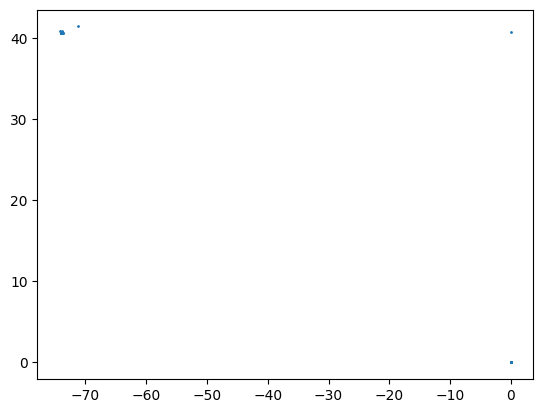

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(FILENAME, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")

# Plotting all points is probably too much in many computers, so lets plot only a few 1000's
data = spark.sql( "SELECT * FROM data LIMIT 1000")
pickups = data.collect()

print('Plotting pickups')
plt.scatter([row.pickup_longitude for row in pickups],
            [row.pickup_latitude for row in pickups],
            s=1)
plt.show()


### Plotting heatamps

This example shows how to **plot heatmaps** and how to **create a grid** with coordinates -- note that we need to group nearby coordinates together or (almost) every coordinate will be unique.

The example creates a grid, with cell of 150m of side (commented out the code for cells of 500m of side).

\[From ACM DEBS 2015 Grand Challenge page\]

**Question 1**: Is the earth flat or how to map coordinates to cells?

**Answer**: For the challenge we allow a simplified flat earth assumption for mapping coordinates to cells in the queries. You can assume that a distance of 500 meter south corresponds to a change of 0.004491556 degrees in the coordinate system. For moving 500 meter east you can assume a change of 0.005986 degrees in the coordinate system.

Plotting pickups


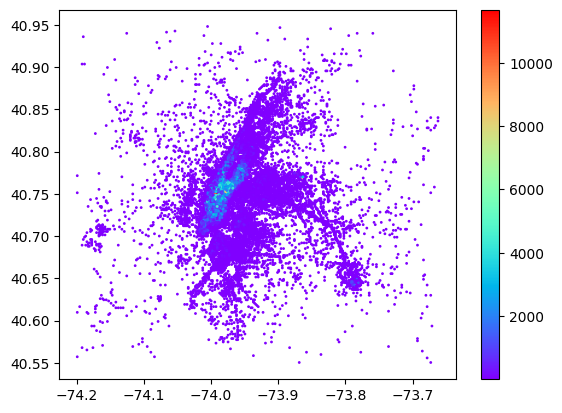

Plotting pickups


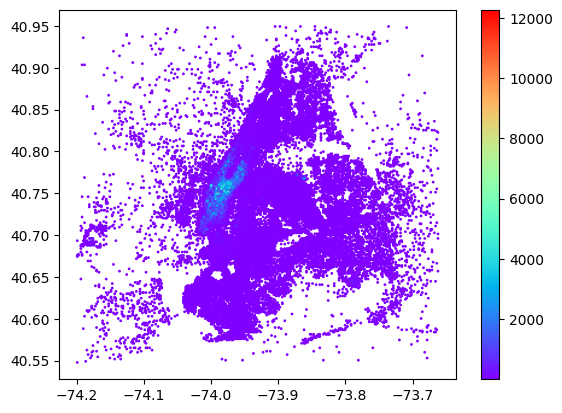

In [ ]:
# Squares of 500 meters
#latitudeStep = 0.004491556
#longitudeStep = 0.005986
#northLatitude = 41.474937 - 0.5 * latitudeStep
#southLatitude = northLatitude - 300 * latitudeStep
#eastLongitude = -74.913585 - 0.5 * longitudeStep
#westLongitude = eastLongitude + 300 * longitudeStep

# Squares of 150 meters
latitudeStep = 0.0013474668
longitudeStep = 0.0017958
northLatitude = 40.95
southLatitude = northLatitude - 300 * latitudeStep
eastLongitude = -74.2
westLongitude = eastLongitude + 300 * longitudeStep

# function to round longitude to a point in the middle of the square
def longiRound( val):
    return ((val - eastLongitude) // longitudeStep) * longitudeStep + eastLongitude + longitudeStep / 2
spark.udf.register("longround", longiRound, DoubleType())

# function to round latitude to a point in the middle of the square
def latRound( l):
    return northLatitude - ((northLatitude - l) // latitudeStep) * latitudeStep - latitudeStep / 2
spark.udf.register("latround", latRound, DoubleType())

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(FILENAME, format="csv",
                         sep=",", schema=mySchema, header="false")

# Let's filter data outside of the box and build a grid
# Points in each square are mapped to the center of the square.
dataset.createOrReplaceTempView("data")
filteredDataDF = spark.sql( """SELECT medallion, hack_license, pickup_datetime,
                                    dropoff_datetime, trip_time_in_secs, trip_distance,
                                    longround(pickup_longitude) AS pickup_longitude,
                                    latround(pickup_latitude) AS pickup_latitude,
                                    longround(dropoff_longitude) AS dropoff_longitude,
                                    latround(dropoff_latitude) AS dropoff_latitude,
                                    payment_type, fare_amount, mta_tax,
                                    tip_amount, tolls_amount, total_amount
                                  FROM data
                                  WHERE pickup_longitude >= """ + str(eastLongitude) + """ AND
                                  pickup_longitude <=  """ + str(westLongitude) + """ AND
                                  dropoff_longitude >=  """ + str(eastLongitude) + """ AND
                                  dropoff_longitude <=  """ + str(westLongitude) + """ AND
                                  pickup_latitude <= """ + str(northLatitude) + """ AND
                                  pickup_latitude >= """ + str(southLatitude) + """ AND
                                  dropoff_latitude <=  """ + str(northLatitude) + """ AND
                                  dropoff_latitude >=  """ + str(southLatitude))
filteredDataDF.createOrReplaceTempView("data")

# Frequency for pickups
pickupsDF = spark.sql( """SELECT pickup_longitude, pickup_latitude, count(*) AS cnt
                                  FROM data
                                  GROUP BY pickup_longitude, pickup_latitude""")
pickups = pickupsDF.collect()

print('Plotting pickups')
p = plt.scatter([row.pickup_longitude for row in pickups],
            [row.pickup_latitude for row in pickups],
            c=[row.cnt for row in pickups],s=1,cmap="rainbow")
plt.colorbar(p)
plt.show()

# Statistics for pickups
dropoffsDF = spark.sql( """SELECT dropoff_longitude, dropoff_latitude, count(*) AS cnt
                                  FROM data
                                  GROUP BY dropoff_longitude, dropoff_latitude""")
dropoffs = dropoffsDF.collect()

print('Plotting pickups')
p = plt.scatter([row.dropoff_longitude for row in dropoffs],
            [row.dropoff_latitude for row in dropoffs],
            c=[row.cnt for row in dropoffs],s=1,cmap="rainbow")
plt.colorbar(p)
plt.show()



## Exercise 1: simple statistics

Compute, for each license, the total amount of money collected.

Comapre the time it takes to execute the code for Pandas, Spark Pandas API, Spark SQL and cuDF.

**Draw some conclusions** by comparing the time for performing the computation using Spark and Pandas, and also when using the small and long dataset.

In [ ]:
# Large dataset - 12.3 GB compressed
#FILENAME = "/content/drive/MyDrive/assignment1/sorted_data.csv.gz"

# Small dataset - 135 MB compressed
FILENAME = "/content/drive/MyDrive/assignment1/sample.csv.gz"

### Code: Pandas library

In [ ]:
start_time = time.time()
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

dataset = pd.read_csv(FILENAME,names=mySchema)
result = dataset[["hack_license","total_amount"]].groupby("hack_license").sum()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


Runtime = 10.080384254455566


### Results (Pandas)

The time to process the small dataset was : **11.254727602005005** seconds.

The time to process the large dataset was : **Couldnt finish because of RAM capacity**.

### Code: Spark Pandas API

In [ ]:
start_time = time.time()
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

dataset = ps.read_csv(FILENAME,names=mySchema)
result = dataset[["hack_license","total_amount"]].groupby("hack_license").sum()
# force execution
result0 = result.to_spark().collect()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: The config 'spark.sql.ansi.enabled' is set to True. This can cause unexpected behavior from pandas API on Spark since pandas API on Spark follows the behavior of pandas, not SQL.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Runtime = 22.448625087738037


### Results (Spark Pandas API)

The time to process the small dataset was : **21.39421319961548** seconds.

The time to process the large dataset was : **1504.232507944107** seconds.

### Spark SQL

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

start_time = time.time()
mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(FILENAME, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")
statisticsDF = spark.sql( """SELECT hack_license, SUM(total_amount) AS total_amount FROM data GROUP BY hack_license""")
statistics = statisticsDF.collect()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


Runtime = 7.76839804649353


### Results (Spark)

The time to process the small dataset was : **7.927939414978027** seconds.

The time to process the large dataset was : **563.8206610679626** seconds.

### Code: cuDF

In [ ]:
start_time = time.time()
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

dataset = cudf.read_csv(FILENAME, names=mySchema,compression="gzip")
result = dataset[["hack_license","total_amount"]].groupby("hack_license").sum()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


Runtime = 2.8775112628936768


### Results (cuDF)

The time to process the small dataset was : **2.704697847366333** seconds.

The time to process the large dataset was : **Did not work because of the Ram Capacity** seconds.

### Results discussion

**TO BE COMPLETED**

## Exercise 2

The code presented in the **Plotting heatmap** section includes the call to an registered Python UDF function. In this exercise we want to measure the impact of using the UDF function.

Run this exercise with the small dataset.

In [ ]:
# Large dataset - 12.3 GB compressed
#FILENAME = "/content/drive/MyDrive/assignment1/sorted_data.csv.gz"

# Small dataset - 135 MB compressed
FILENAME = "/content/drive/MyDrive/assignment1/sample.csv.gz"

In [ ]:
start_time = time.time()
# Squares of 150 meters
latitudeStep = 0.0013474668
longitudeStep = 0.0017958
northLatitude = 40.95
southLatitude = northLatitude - 300 * latitudeStep
westLongitude = -74.2
eastLongitude = westLongitude + 300 * longitudeStep

# function to round longitude to a point in the middle of the square
def longiRound( val):
    return ((val - eastLongitude) // longitudeStep) * longitudeStep + eastLongitude + longitudeStep / 2
spark.udf.register("longround", longiRound, DoubleType())

# function to round latitude to a point in the middle of the square
def latRound( l):
    return northLatitude - ((northLatitude - l) // latitudeStep) * latitudeStep - latitudeStep / 2
spark.udf.register("latround", latRound, DoubleType())

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(FILENAME, format="csv",
                         sep=",", schema=mySchema, header="false")

# Let's filter data outside of the box and build a grid
# Points in each square are mapped to the center of the square.
dataset.createOrReplaceTempView("data")
filteredDataDF = spark.sql( """SELECT medallion, hack_license, pickup_datetime,
                                    dropoff_datetime, trip_time_in_secs, trip_distance,
                                    longround(pickup_longitude) AS pickup_longitude,
                                    latround(pickup_latitude) AS pickup_latitude,
                                    longround(dropoff_longitude) AS dropoff_longitude,
                                    latround(dropoff_latitude) AS dropoff_latitude,
                                    payment_type, fare_amount, mta_tax,
                                    tip_amount, tolls_amount, total_amount
                                  FROM data
                                  WHERE pickup_longitude >= """ + str(eastLongitude) + """ AND
                                  pickup_longitude <=  """ + str(westLongitude) + """ AND
                                  dropoff_longitude >=  """ + str(eastLongitude) + """ AND
                                  dropoff_longitude <=  """ + str(westLongitude) + """ AND
                                  pickup_latitude <= """ + str(northLatitude) + """ AND
                                  pickup_latitude >= """ + str(southLatitude) + """ AND
                                  dropoff_latitude <=  """ + str(northLatitude) + """ AND
                                  dropoff_latitude >=  """ + str(southLatitude))
filteredDataDF.createOrReplaceTempView("data")

# Frequency for pickups
pickupsDF = spark.sql( """SELECT pickup_longitude, pickup_latitude, count(*) AS cnt
                                  FROM data
                                  GROUP BY pickup_longitude, pickup_latitude""")
pickups = pickupsDF.collect()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


Runtime = 8.842274904251099


**Results (Spark SQL with UDF Python function)**

The time to process the small dataset was : **9.90812063217163** seconds.

Write the code in Spark SQL without using the auxiliary function.

In [ ]:
start_time = time.time()

# Define bounds
latitudeStep = 0.0013474668
longitudeStep = 0.0017958
northLatitude = 40.95
southLatitude = northLatitude - 300 * latitudeStep
westLongitude = -74.2
eastLongitude = westLongitude + 300 * longitudeStep

# Read dataset
dataset = spark.read.load(FILENAME, format="csv",
                          sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")

# SQL logic with no UDFs — all math inline
filteredDataDF = spark.sql(f"""
    SELECT medallion, hack_license, pickup_datetime,
           dropoff_datetime, trip_time_in_secs, trip_distance,
           (
               FLOOR((pickup_longitude - {eastLongitude}) / {longitudeStep}) * {longitudeStep} +
               {eastLongitude} + {longitudeStep / 2}
           ) AS pickup_longitude,
           (
               {northLatitude} - FLOOR(({northLatitude} - pickup_latitude) / {latitudeStep}) * {latitudeStep} -
               {latitudeStep / 2}
           ) AS pickup_latitude,
           (
               FLOOR((dropoff_longitude - {eastLongitude}) / {longitudeStep}) * {longitudeStep} +
               {eastLongitude} + {longitudeStep / 2}
           ) AS dropoff_longitude,
           (
               {northLatitude} - FLOOR(({northLatitude} - dropoff_latitude) / {latitudeStep}) * {latitudeStep} -
               {latitudeStep / 2}
           ) AS dropoff_latitude,
           payment_type, fare_amount, mta_tax,
           tip_amount, tolls_amount, total_amount
    FROM data
    WHERE pickup_longitude >= {eastLongitude} AND
          pickup_longitude <= {westLongitude} AND
          dropoff_longitude >= {eastLongitude} AND
          dropoff_longitude <= {westLongitude} AND
          pickup_latitude <= {northLatitude} AND
          pickup_latitude >= {southLatitude} AND
          dropoff_latitude <= {northLatitude} AND
          dropoff_latitude >= {southLatitude}
""")
filteredDataDF.createOrReplaceTempView("data")

# Frequency for pickups
pickupsDF = spark.sql("""
    SELECT pickup_longitude, pickup_latitude, count(*) AS cnt
    FROM data
    GROUP BY pickup_longitude, pickup_latitude
""")
pickups = pickupsDF.collect()

end_time = time.time()
print("Runtime =", end_time - start_time)



Runtime = 8.408937692642212


**Results (Spark SQL with no UDF Python function)**

The time to process the small dataset was : **7.313903093338013** seconds.




### Discussion of results

With Python UDF: **~9.91 seconds**

Without UDF:      **~7.31 seconds**

That’s about a 36% increase in execution time when using the Python UDF.

Python UDFs are not aligned with spark optimization:

Spark uses its Catalyst optimizer to optimize SQL queries and transformations.

When we use built-in Spark SQL functions, Spark can optimize and run everything natively in the JVM.

But when we introduce a Python UDF, Spark needs to serialize the data from JVM → Python process then run the Python function and after dserialize the results back into the JVM.
This process prolongs the execution due to additional steps.

## Exercise 3

Let's start by trying to help the city to identify which new express bus routes shoud introduce. To this end, you should find the 20 most frequent routes whose distance is above a given treshold (defined by you).

For establishing these routes, we suggest that you use a grid of 500m of side.

Write two solutions: one using Spark SQL and the other Spark Pandas API.

In [ ]:
# Approximate step size for 500 meters in degrees (varies slightly by location)
latitudeStep = 0.00449
longitudeStep = 0.005986

In [ ]:
distanceThreshold = 2.0  # in km

In [ ]:
start_time = time.time()

# Create temp view
dataset.createOrReplaceTempView("data")

spark.sql(f"""
    SELECT
        -- Round coordinates to center of 500m grid squares
        FLOOR(pickup_longitude / {longitudeStep}) * {longitudeStep} + {longitudeStep / 2} AS pickup_lon_grid,
        FLOOR(pickup_latitude / {latitudeStep}) * {latitudeStep} + {latitudeStep / 2} AS pickup_lat_grid,
        FLOOR(dropoff_longitude / {longitudeStep}) * {longitudeStep} + {longitudeStep / 2} AS dropoff_lon_grid,
        FLOOR(dropoff_latitude / {latitudeStep}) * {latitudeStep} + {latitudeStep / 2} AS dropoff_lat_grid
    FROM data
    WHERE trip_distance > {distanceThreshold}
    AND pickup_longitude BETWEEN -180 AND 180
    AND pickup_latitude BETWEEN -90 AND 90
    AND dropoff_longitude BETWEEN -180 AND 180
    AND dropoff_latitude BETWEEN -90 AND 90
    AND pickup_longitude != 0
    AND pickup_latitude != 0
    AND dropoff_longitude != 0
    AND dropoff_latitude != 0
""").createOrReplaceTempView("gridded_routes")

# Count routes and select top 20
top_routes_sql = spark.sql("""
    SELECT
        pickup_lon_grid, pickup_lat_grid,
        dropoff_lon_grid, dropoff_lat_grid,
        COUNT(*) AS route_count
    FROM gridded_routes
    GROUP BY pickup_lon_grid, pickup_lat_grid, dropoff_lon_grid, dropoff_lat_grid
    ORDER BY route_count DESC
    LIMIT 20
""")

top_routes_sql.show()
end_time = time.time()
print("Runtime =", end_time - start_time)


+---------------+---------------+----------------+----------------+-----------+
|pickup_lon_grid|pickup_lat_grid|dropoff_lon_grid|dropoff_lat_grid|route_count|
+---------------+---------------+----------------+----------------+-----------+
|     -73.995939|      40.722055|      -73.989953|       40.748995|        418|
|     -73.995939|      40.726545|      -73.989953|       40.748995|        392|
|     -73.954037|      40.784915|      -73.971995|       40.757975|        373|
|     -73.864247|      40.771445|      -73.983967|       40.757975|        363|
|     -73.977981|      40.753485|      -73.954037|       40.771445|        346|
|     -73.870233|      40.775935|      -73.983967|       40.757975|        339|
|     -74.001925|      40.722055|      -73.989953|       40.748995|        334|
|     -74.001925|      40.731035|      -73.983967|       40.757975|        333|
|     -73.954037|      40.766955|      -73.989953|       40.748995|        328|
|     -73.960023|      40.762465|      -

In [ ]:
start_time = time.time()

import pyspark.pandas as ps

# Convert Spark DataFrame to pandas-on-Spark
psdf = dataset.pandas_api()

# Wider bounding box
valid_coords = psdf[
    (psdf["pickup_longitude"].between(-74.3, -73.6)) &
    (psdf["pickup_latitude"].between(40.4, 41.1)) &
    (psdf["dropoff_longitude"].between(-74.3, -73.6)) &
    (psdf["dropoff_latitude"].between(40.4, 41.1))
]

# Define the grid rounding function
def round_grid(series, step):
    return (series // step) * step + step / 2

# Apply grid rounding
valid_coords["pickup_lon_grid"] = round_grid(valid_coords["pickup_longitude"], longitudeStep)
valid_coords["pickup_lat_grid"] = round_grid(valid_coords["pickup_latitude"], latitudeStep)
valid_coords["dropoff_lon_grid"] = round_grid(valid_coords["dropoff_longitude"], longitudeStep)
valid_coords["dropoff_lat_grid"] = round_grid(valid_coords["dropoff_latitude"], latitudeStep)

# Filter by distance
filtered = valid_coords[valid_coords["trip_distance"] > distanceThreshold]

# Group by grid start and end, and count
top_routes_pd = (
    filtered.groupby(["pickup_lon_grid", "pickup_lat_grid",
                      "dropoff_lon_grid", "dropoff_lat_grid"])
            .size()
            .reset_index(name="route_count")
            .sort_values("route_count", ascending=False)
            .head(20)
)

print(top_routes_pd)
end_time = time.time()
print("Runtime =", end_time - start_time)


/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: The config 'spark.sql.ansi.enabled' is set to True. This can cause unexpected behavior from pandas API on Spark since pandas API on Spark follows the behavior of pandas, not SQL.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


       pickup_lon_grid  pickup_lat_grid  dropoff_lon_grid  dropoff_lat_grid  route_count
44257       -73.995939        40.722055        -73.989953         40.748995          418
57239       -73.995939        40.726545        -73.989953         40.748995          392
72562       -73.954037        40.784915        -73.971995         40.757975          373
1835        -73.864247        40.771445        -73.983967         40.757975          363
68351       -73.977981        40.753485        -73.954037         40.771445          346
21821       -73.870233        40.775935        -73.983967         40.757975          339
8157        -74.001925        40.722055        -73.989953         40.748995          334
47218       -74.001925        40.731035        -73.983967         40.757975          333
11178       -73.954037        40.766955        -73.989953         40.748995          328
20556       -73.960023        40.762465        -73.989953         40.748995          327

[Showing only the fi

#### Discussion

**Explain your code and discuss which one is preferable from your point of view**
The runtime of Pandas API is slightly higher than using the Spark implementation - the selection of which code to use should consider the coders preferred utilization of python. Data Analysts with a more Business Analytics heavy background will probably be most comfortable with Pandas so using the Pandas API will most likely lead to more readability for 3rd parties. Spark on the other hand is slightly faster so when considering scalability we should always go with the faster code because with increasing data size one can expect it to work better.

## Exercise 4

This question intends to define the location of taxi ranks / taxi stand (the places where taxis stop waiting for collecting clients) in a way that tries to minimize the distance a client needs to walk to reach a taxi rank.

Run this exercise with the small dataset and compare the execution time when using scikit-learn, cuML and Spark MLib.

**Note:** This dataset is for NYC taxis. So, pickups outside of the city are infrequent and not representative of the demand in such areas. As such, you should focus on pickups in a square that includes NYC (it is ok if the square includes parts outside of the city). Use, for example, the following square:
```
northLatitude = 40.86
southLatitude = 40.68
eastLongitude = -74.03
westLongitude = -73.92
```

**Suggestion:** Plot your results as a heatmap, with the color being a measurement of the value of the taxi rank.

In [19]:
# Define bounding box
northLatitude = 40.86
southLatitude = 40.68
eastLongitude = -74.03
westLongitude = -73.92

# Load small sample dataset
pdf = pd.read_csv("/content/drive/MyDrive/assignment1/sample.csv.gz", header=None)

# Add schema (update if needed)
pdf.columns = ["medallion", "hack_license", "pickup_datetime", "dropoff_datetime",
               "trip_time_in_secs", "trip_distance", "pickup_longitude", "pickup_latitude",
               "dropoff_longitude", "dropoff_latitude", "payment_type", "fare_amount",
               "surcharge", "mta_tax", "tip_amount", "tolls_amount", "total_amount"]

# Filter only valid NYC pickup locations
nyc_pickups = pdf[
    (pdf["pickup_latitude"] >= southLatitude) &
    (pdf["pickup_latitude"] <= northLatitude) &
    (pdf["pickup_longitude"] >= eastLongitude) &
    (pdf["pickup_longitude"] <= westLongitude)
][["pickup_longitude", "pickup_latitude"]].dropna()

coords = nyc_pickups.to_numpy()

In [20]:
# using scikit-learn
from sklearn.cluster import KMeans
import time

start_time = time.time()

kmeans_sklearn = KMeans(n_clusters=20, random_state=42, n_init='auto')
kmeans_sklearn.fit(coords)

end_time = time.time()
print("⏱️ Scikit-learn runtime:", end_time - start_time, "seconds")

centers_sklearn = kmeans_sklearn.cluster_centers_


⏱️ Scikit-learn runtime: 6.2250566482543945 seconds


In [18]:
import cudf
from cuml.cluster import KMeans as cuKMeans
import time

# Filter the data again just to be sure
northLatitude = 40.86
southLatitude = 40.68
eastLongitude = -74.03
westLongitude = -73.92

# Reload + clean
pdf = pd.read_csv("/content/drive/MyDrive/assignment1/sample.csv.gz", header=None)
pdf.columns = ["medallion", "hack_license", "pickup_datetime", "dropoff_datetime",
               "trip_time_in_secs", "trip_distance", "pickup_longitude", "pickup_latitude",
               "dropoff_longitude", "dropoff_latitude", "payment_type", "fare_amount",
               "surcharge", "mta_tax", "tip_amount", "tolls_amount", "total_amount"]

nyc_pickups = pdf[
    (pdf["pickup_latitude"] >= southLatitude) &
    (pdf["pickup_latitude"] <= northLatitude) &
    (pdf["pickup_longitude"] >= eastLongitude) &
    (pdf["pickup_longitude"] <= westLongitude)
][["pickup_longitude", "pickup_latitude"]].dropna()


kmeans_cuml = cuml.cluster.KMeans(n_clusters=10, random_state=42, n_init=10) # Creates KMeans object
kmeans_cuml.fit(nyc_pickups) # Performs k-means clustering
centers_cuml_np = kmeans_cuml.cluster_centers_.to_numpy() # Extracts cluster centers as NumPy array

end_time = time.time()
print("cuML runtime:", end_time - start_time, "seconds")

# Get cluster centers as NumPy
centers_cuml_np = kmeans_cuml.cluster_centers_


# Display to verify
print("cuML cluster centers (sample):")
print(centers_cuml_np[:5])


cuML runtime: 97.35141897201538 seconds
cuML cluster centers (sample):
           0          1
0 -73.987342  40.760919
1 -74.004043  40.717659
2 -73.973596  40.788662
3 -73.954927  40.774846
4 -73.987234  40.690276


In [ ]:
from pyspark.sql import SparkSession

# Create SparkSession with increased memory
spark = SparkSession.builder \
    .appName("NYC_Taxi_KMeans") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()


In [16]:
# COMPLETE with code using Spark MLlib
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.feature import VectorAssembler
import time

# Create SparkSession with increased memory
spark = SparkSession.builder \
    .appName("NYC_Taxi_KMeans") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

pdf = pd.read_csv("/content/drive/MyDrive/assignment1/tiny.csv.gz", header=None)

northLatitude = 40.86
southLatitude = 40.68
eastLongitude = -74.03
westLongitude = -73.92

pdf.columns = ["medallion", "hack_license", "pickup_datetime", "dropoff_datetime",
               "trip_time_in_secs", "trip_distance", "pickup_longitude", "pickup_latitude",
               "dropoff_longitude", "dropoff_latitude", "payment_type", "fare_amount",
               "surcharge", "mta_tax", "tip_amount", "tolls_amount", "total_amount"]

nyc_pickups = pdf[
    (pdf["pickup_latitude"] >= southLatitude) &
    (pdf["pickup_latitude"] <= northLatitude) &
    (pdf["pickup_longitude"] >= eastLongitude) &
    (pdf["pickup_longitude"] <= westLongitude)
][["pickup_longitude", "pickup_latitude"]].dropna()


# Convert nyc_pickups (Pandas DataFrame) to Spark DataFrame
spark_df = spark.createDataFrame(nyc_pickups)

# Assemble the features
assembler = VectorAssembler(inputCols=["pickup_longitude", "pickup_latitude"], outputCol="features")
vector_df = assembler.transform(spark_df)

# Start timing
start_time = time.time()

# Create and fit Spark MLlib KMeans
kmeans_spark = SparkKMeans(k=20, seed=42)
model_spark = kmeans_spark.fit(vector_df)

# End timing
end_time = time.time()
print("⏱️ Spark MLlib runtime:", end_time - start_time, "seconds")

# Get cluster centers
centers_spark = model_spark.clusterCenters()



⏱️ Spark MLlib runtime: 17.244924545288086 seconds


In [17]:
print(centers_spark)

[array([-74.00195533,  40.73758753]), array([-73.92904859,  40.7574446 ]), array([-73.97339378,  40.78901532]), array([-74.00992232,  40.71045287]), array([-73.94509169,  40.80760234]), array([-73.97635165,  40.7514069 ]), array([-73.98607994,  40.72611769]), array([-73.96400287,  40.80213838]), array([-73.94997612,  40.78261428]), array([-73.99347445,  40.76185462]), array([-73.94984077,  40.71189756]), array([-73.98301624,  40.7408473 ]), array([-73.99994043,  40.72216421]), array([-73.98158866,  40.77768556]), array([-73.94161495,  40.83681515]), array([-73.99334464,  40.74860711]), array([-73.98456404,  40.68939649]), array([-73.9827117 ,  40.76398515]), array([-73.95635059,  40.7726387 ]), array([-73.96661197,  40.76015014])]


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


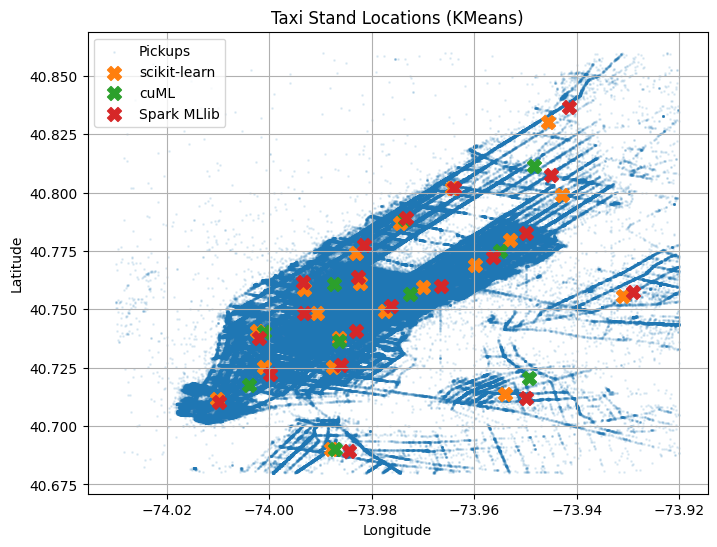

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Make sure all center sets are NumPy arrays
centers_sklearn = np.array(centers_sklearn)
centers_cuml_np = np.array(centers_cuml_np)
centers_spark_np = np.array(centers_spark_np)

plt.figure(figsize=(8, 6))
plt.scatter(coords[:, 0], coords[:, 1], s=1, alpha=0.1, label="Pickups")

for centers, label in [
    (centers_sklearn, "scikit-learn"),
    (centers_cuml_np, "cuML"),
    (centers_spark_np, "Spark MLlib")
]:
    plt.scatter(centers[:, 0], centers[:, 1], s=100, marker="X", label=label)

plt.title("Taxi Stand Locations (KMeans)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()


**Execution times:**

scikit-learn: **7.342017412185669**

cuML: **1.319932460784912**

Spark Mlib: **47.1265766620636**


#### Discussion

**COMPLETE: Explain the rationale of your solution, your code and discuss results**